In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import collections
import copy

In [2]:
def gen_data(n, d, w, gamma, p):
    ys = torch.distributions.Bernoulli(torch.tensor(p)).sample((n, 1))
    zs = torch.randn(n, d)
    xs = zs + gamma * (2*ys-1) * w
    return xs.float(), ys

In [3]:
def bayes_accuracy(xs, ys, w, gamma, p):
    temp = 1/(1+torch.exp(2*gamma*torch.matmul(xs, w)))
    preds = temp <= p
    return (preds == ys[:,0]).float().mean()

In [4]:
def train_on_source(xTrain, yTrain, xTest, yTest):
    '''
    Trains a logistic regression model on the source dataset and returns the model.
    '''
    model = nn.Sequential(nn.Linear(xTrain.shape[1], 1))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    for i in tqdm(range(10000)):
        optimizer.zero_grad()
        outputs = torch.sigmoid(model(xTrain))
        loss = F.binary_cross_entropy(outputs, yTrain)
        loss.backward()
        optimizer.step()
    return model

In [11]:
def adapt(model, xTarget, epochs = 100000):
    '''
    Adapts the model to the target dataset and returns the adapted model.
    Current code uses Adam since the SGD was very slow.
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        outputs = model(xTarget)
        
        # probsPred = torch.sigmoid(outputs)
        # labelPreds = (probsPred > 0.5).float().detach()
        # loss = F.binary_cross_entropy(probsPred, labelPreds)

        labelPreds = (outputs > 0).float().detach()
        loss = torch.mean(torch.clamp(1 - outputs.t() * labelPreds, min=0))
        # loss = torch.mean(torch.exp(-outputs.t() * labelPreds))
        loss.backward()
        optimizer.step()
    return model

In [6]:
def evaluate(model, x, y):
    return((model(x) > 0) == y).float().mean().item()

In [7]:
n = 1000
d = 1
w = torch.ones(d)/np.sqrt(d)
gamma = 0.3
pSource = 0.5
pTarget = 0.9

In [10]:
xSourceTrain, ySourceTrain = gen_data(n, d, w, gamma, pSource)
xSourceTest, ySourceTest = gen_data(n, d, w, gamma, pSource)

xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, pTarget)
xTargetTest, yTargetTest = gen_data(n, d, w, gamma, pTarget)

In [11]:
bAccuSource = bayes_accuracy(xSourceTest, ySourceTest, w, gamma, pSource)
bAccuTarget = bayes_accuracy(xTargetTest, yTargetTest, w, gamma, pTarget)
print("Bayes accuracy on source is:", bAccuSource)
print("Bayes accuracy on target is:", bAccuTarget)

Bayes accuracy on source is: tensor(0.6270)
Bayes accuracy on target is: tensor(0.9100)


In [ ]:
model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
print("Accuracy on source is:", evaluate(model, xSourceTest, ySourceTest))
print("Accuracy on target is:", evaluate(model, xTargetTest, yTargetTest))

model = adapt(model, xTargetTrain)
print("Accuracy on source is:", evaluate(model, xSourceTest, ySourceTest))
print("Accuracy on target is:", evaluate(model, xTargetTest, yTargetTest))

100%|██████████| 10000/10000 [00:03<00:00, 2926.26it/s]


Accuracy on source is: 0.8349999785423279
Accuracy on target is: 0.8420000076293945


100%|██████████| 1000000/1000000 [09:19<00:00, 1787.10it/s]

Accuracy on source is: 0.7379999756813049
Accuracy on target is: 0.9210000038146973


In [ ]:
# pot the target data and the initial and adapted decision boundaries
plt.figure(figsize=(10,10))
plt.scatter(xTargetTest[:,0], xTargetTest[:,1], c=yTargetTest[:,0], cmap='bwr')
plot_decision_boundary2(model)
plt.show()

In [12]:
accusBeforeAdapt = collections.defaultdict(list)
accusAfterAdapt = collections.defaultdict(list)
bayesAccus = collections.defaultdict(list)

data = collections.defaultdict(dict)



torch.manual_seed(0)
reps = 1
for _ in range(reps):
    xSourceTrain, ySourceTrain = gen_data(n, d, w, gamma, pSource)
    xSourceTest, ySourceTest = gen_data(n, d, w, gamma, pSource)
    model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
    data[_]['Source'] = [xSourceTrain, ySourceTrain, xSourceTest, ySourceTest]
    data[_]['Source_Model'] = copy.deepcopy(model)
    for i in range(10):
        p = 0.5 + i/20
        xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, p)
        xTargetTest, yTargetTest = gen_data(n, d, w, gamma, p)
        data[_][p] = [xTargetTrain, yTargetTrain, xTargetTest, yTargetTest]
        
        bAccuTarget = bayes_accuracy(xTargetTest, yTargetTest, w, gamma, p)
        bayesAccus[p].append(bAccuTarget)
        
        temp_model = copy.deepcopy(model)
        accusBeforeAdapt[p].append(evaluate(temp_model, xTargetTest, yTargetTest))
        temp_model = adapt(temp_model, xTargetTrain)
        accusAfterAdapt[p].append(evaluate(temp_model, xTargetTest, yTargetTest))
        data[_][str(p)+'_Model'] = copy.deepcopy(temp_model)
        print(" Accu after adapt for", p, "is", accusAfterAdapt[p][-1])
# for p in accusAfterAdapt:
#     accusBeforeAdapt[p] /= reps
#     accusAfterAdapt[p] /= reps
#     bayesAccus[p] /= reps

100%|██████████| 100000/100000 [05:21<00:00, 310.92it/s]


 Accu after adapt for 0.5 is 0.5


 27%|██▋       | 26558/100000 [01:14<03:27, 354.17it/s]


KeyboardInterrupt: 

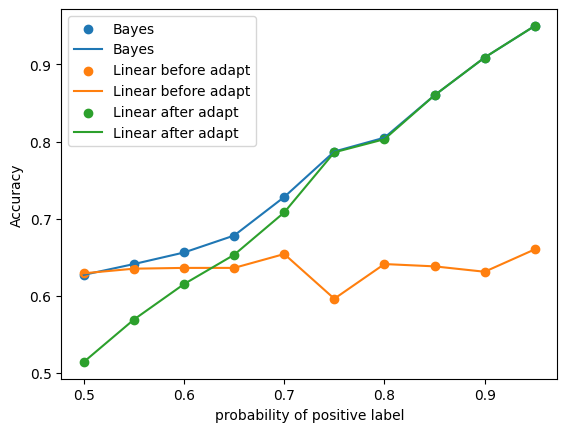

In [15]:
plt.scatter(list(bayesAccus.keys()), list(bayesAccus.values()), label="Bayes")
plt.plot(list(bayesAccus.keys()), list(bayesAccus.values()), label="Bayes")
plt.scatter(list(accusBeforeAdapt.keys()), list(accusBeforeAdapt.values()), label="Linear before adapt")
plt.plot(list(accusBeforeAdapt.keys()), list(accusBeforeAdapt.values()), label="Linear before adapt")
plt.scatter(list(accusAfterAdapt.keys()), list(accusAfterAdapt.values()), label="Linear after adapt")
plt.plot(list(accusAfterAdapt.keys()), list(accusAfterAdapt.values()), label="Linear after adapt")
plt.xlabel("probability of positive label")
plt.title("n={}, d={}, w={}, gamma={}, lr={}, epochs={}".format(n, d, w, gamma, 0.0001, 100000))
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
def plot_decision_boundary2(model):
    # given a linear model plot the decision boundary using the weights of the linear layer
    w = model[0].weight.data.numpy()
    b = model[0].bias.data.numpy()
    x = np.linspace(-3, 3, 100)
    y = -w[0][0]/w[0][1] * x - b[0]/w[0][1]
    plt.plot(x, y, label="Decision Boundary")
    plt.legend()
    

In [ ]:
# for each p count the number of points predicted as positive 
for p in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    model = data[0]['Source_Model']
    xTargetTest, yTargetTest = data[0][p][2], data[0][p][3]
    probs = torch.sigmoid(model(xTargetTest))
    preds = (probs > 0.5).float().detach()
    print("Number of positive predictions for", p, "is", preds.sum().item())

In [ ]:
# for each p count the number of points predicted as positive 
for p in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    model = data[0]['Source_Model']
    xTargetTest, yTargetTest = data[0][p][2], data[0][p][3]
    probs = torch.sigmoid(model(xTargetTest))
    preds = (probs > 0.5).float().detach()
    entropyByPredPos = F.binary_cross_entropy(probs[preds==1], preds[preds==1], reduction='none')
    entropyByPredNeg = F.binary_cross_entropy(probs[preds==0], preds[preds==0], reduction='none')
    print("Entropy for p =", p, "is", entropyByPredPos.mean().item(), entropyByPredNeg.mean().item())

In [ ]:
def plot_decision_boundary(model):
    # obtain meshgrid of points
    x = np.linspace(-2, 2, 200)
    y = np.linspace(-2, 2, 200)
    xx, yy = np.meshgrid(x, y)
    # flatten the meshgrid and stack them together
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    xx_flat = torch.tensor(xx_flat, dtype=torch.float32)
    yy_flat = torch.tensor(yy_flat, dtype=torch.float32)
    xy_flat = torch.stack([xx_flat, yy_flat], dim=1)
    # obtain predictions
    model.eval()
    with torch.no_grad():
        pred = model(xy_flat)
        pred = pred.squeeze()
        # keep the points where the probability is between 0.4 and 0.6
        mask = (pred > 0.45) & (pred < 0.55)
        xx_flat = xx_flat[mask]
        yy_flat = yy_flat[mask]
    # plot the points
    plt.scatter(xx_flat, yy_flat, s=0.5, c='r')

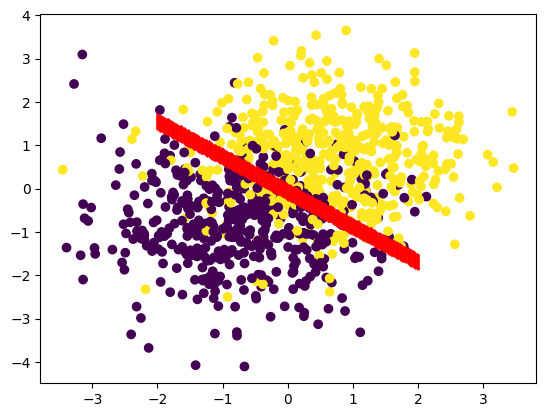

In [ ]:
plt.scatter(xSourceTrain[:, 0], xSourceTrain[:, 1], c=ySourceTrain, marker='o')
# plt.scatter(xTargetTrain[:, 0], xTargetTrain[:, 1], c=yTargetTrain, marker='x')
plot_decision_boundary(model)
plt.show()

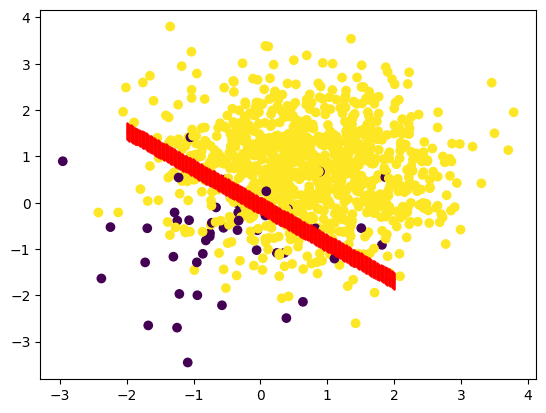

In [ ]:
# plt.scatter(xSourceTrain[:, 0], xSourceTrain[:, 1], c=ySourceTrain, marker='o')
plt.scatter(xTargetTrain[:, 0], xTargetTrain[:, 1], c=yTargetTrain, marker='o')
plot_decision_boundary(model)
plt.show()

In [ ]:

# for each _ in data (reps) plot the source test data and the decision boundary

for _ in data:
    plt.scatter(data[_]['Source'][0][:, 0], data[_]['Source'][0][:, 1], c=data[_]['Source'][1], marker='o')
    plot_decision_boundary(data[_]['Model'])
    plt.show()
    

In [ ]:
# for each p in _=0 plot the target test data and the decision boundary
f, ax = plt.subplots(2, 5, figsize=(20, 8))
for i, p in enumerate([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    plt.subplot(2, 4, i+1)
    plt.scatter(data[0][p][2][:, 0], data[0][p][2][:, 1], c=data[0][p][3], marker='o')
    plot_decision_boundary(data[0][str(p)+'_Model'])
    plt.title("p = {}".format(p))
plt.show()


In [ ]:
# for each _ in data (reps) print the source test accuracy and the target test accuracy before adaptation
for _ in data:
    print("Source test accuracy:", evaluate(data[_]['Model'], data[_]['Source'][2], data[_]['Source'][3]))
    for p in data[_]:
        if p != 'Source' and p != 'Model':
            print("Target test accuracy before adaptation for", p, "is", evaluate(data[_]['Model'], data[_][p][2], data[_][p][3]))
    print()

In [ ]:
import plotly
import plotly.graph_objs as go

def optiLandscape(xs, ys):
    # compute the cross entropy loss for each point in the grid where the weight ranges from -2 to 2 and the bias ranges from -2 to 2
    # plot the loss as a function of the weight and bias
    # plot the decision boundary of the model with the lowest loss

    # obtain meshgrid of points
    w = np.linspace(-2, 2, 200)
    b = np.linspace(-2, 2, 200)
    ww, bb = np.meshgrid(w, b)
    # flatten the meshgrid and stack them together
    ww_flat = ww.flatten()
    bb_flat = bb.flatten()
    ww_flat = torch.tensor(ww_flat, dtype=torch.float32)
    bb_flat = torch.tensor(bb_flat, dtype=torch.float32)
    wb_flat = torch.stack([ww_flat, bb_flat], dim=1)
    # obtain predictions
    model = nn.Sequential(nn.Linear(1, 1))
    dic = collections.defaultdict(float)
    for w, b in wb_flat:
        model[0].weight.data = torch.tensor([[w]])
        model[0].bias.data = torch.tensor([b])
        model.eval()
        with torch.no_grad():
            pred = torch.sigmoid(model(xs))
            pred = pred.squeeze()
            dic[(w, b)] = F.binary_cross_entropy(pred, (pred > 0.5).float().detach())
    # do a 3d plot using plotly library
    fig = go.Figure(data=[go.Surface(z=np.array(list(dic.values())).reshape(200, 200), x=ww, y=bb)])
    fig.update_layout(title='Loss Landscape', autosize=False,
                        width=500, height=500,
                        margin=dict(l=65, r=50, b=65, t=90))
    fig.show()


In [ ]:
# print the mean of the datapoints for each label
print(xTargetTrain[yTargetTrain[:, 0] == 0].mean())
print(xTargetTrain[yTargetTrain[:, 0] == 1].mean())

In [5]:
def plotter(x, w):
    bs = np.linspace(-2, 2, 100)
    loss = []
    model = nn.Sequential(nn.Linear(1, 1))
    for b in bs:
        model[0].weight.data = torch.tensor([[w]]).float()
        model[0].bias.data = torch.tensor([b]).float()
        model.eval()
        with torch.no_grad():
            pred = torch.sigmoid(model(x))
            pred = pred.squeeze()
            labelPred = (pred > 0.5).float().detach()
            loss.append(F.binary_cross_entropy(pred, labelPred).item())
    plt.plot(bs, loss, alpha=0.3, label=w)

In [ ]:
f, ax = plt.subplots(2, 5, figsize=(20, 8))
for i, w in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .8, 0.9, 1]):
    plt.subplot(2, 5, i+1)
    plotter(xSourceTrain[ySourceTrain[:, 0] == 0], w)
    plotter(xSourceTrain[ySourceTrain[:, 0] == 1], w)
    plotter(xSourceTrain, w)
    plt.title("w = {}".format(w))
    plt.legend()